## Importing libs and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# obs.: Notebook shortcuts: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
#       pandas' Cheat Sheet: https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
dataset_csv_path = "Metro_Interstate_Traffic_Volume.csv" # 8 attributes of 48,204 examples

# loading the dataset with pandas (instead of numpy or csv) since there are different datatypes
dataset_csv = pd.read_csv(dataset_csv_path, delimiter=',')
dataset_csv.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

_(You may skip to section **0.** after running the three cells above)_

## Dataset attributes
1: **holiday**: US National holidays plus regional holiday, Minnesota State Fair\
2: **temp**: average temp in kelvin\
3: **rain 1h**: amount in mm of rain that occurred in the hour\
4: **snow 1h**: amount in mm of snow that occurred in the hour\
5: **clouds all**: percentage of cloud cover\
6: **weather main**: short textual description of the current weather\
7: **weather description**: longer textual description of the current weather\
8: **date time**: hour of the data collected in local CST time\
target: **traffic volume**: traffic volume

In [4]:
dataset_csv.head(n=10) # peeks into the resulting pandas.DataFrame

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


## Visualizing the data

In [5]:
# obs.: the two following notations are valid, and both return a pandas.Series object
# dataset_csv.date_time
dataset_csv["date_time"]

0        2012-10-02 09:00:00
1        2012-10-02 10:00:00
2        2012-10-02 11:00:00
3        2012-10-02 12:00:00
4        2012-10-02 13:00:00
                ...         
48199    2018-09-30 19:00:00
48200    2018-09-30 20:00:00
48201    2018-09-30 21:00:00
48202    2018-09-30 22:00:00
48203    2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: object

In [6]:
from datetime import datetime
def date_time_dif(str1, str2):
    str_format = "%Y-%m-%d %H:%M:%S"
    dt1 = datetime.strptime(str1, str_format)
    dt2 = datetime.strptime(str2, str_format)
    return (dt1 - dt2)

time_span = date_time_dif(dataset_csv.date_time.iloc[-1], dataset_csv.date_time.iloc[0])

print(dataset_csv["date_time"])
print("\nTime span: " + str(time_span))

0        2012-10-02 09:00:00
1        2012-10-02 10:00:00
2        2012-10-02 11:00:00
3        2012-10-02 12:00:00
4        2012-10-02 13:00:00
                ...         
48199    2018-09-30 19:00:00
48200    2018-09-30 20:00:00
48201    2018-09-30 21:00:00
48202    2018-09-30 22:00:00
48203    2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: object

Time span: 2189 days, 14:00:00


In [7]:
traffic_volume = dataset_csv["traffic_volume"]
min_vol = traffic_volume.min()
max_vol = traffic_volume.max()
print(f"min: {min_vol}, max: {max_vol}, mean: {traffic_volume.mean():.2f}")

min: 0, max: 7280, mean: 3259.82


In [8]:
dataset_csv.query(f"traffic_volume == {min_vol}") # obs.: same as dataset_csv[dataset_csv["traffic_volume"] == min_vol]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
25186,None,296.68,0.0,0.0,40,Rain,light rain,2016-07-23 18:00:00,0
25191,None,295.90,0.0,0.0,90,Haze,haze,2016-07-23 23:00:00,0


In [9]:
# see values around the entries of min traffic volume
display_columns = dataset_csv.columns[~dataset_csv.columns.isin(["holiday", "clouds_all", "weather_description"])]
dataset_csv.iloc[25186 - 3 : 25191 + 4][display_columns].reset_index() # obs.: the original index is in the "index" column

,index,temp,rain_1h,snow_1h,weather_main,date_time,traffic_volume
0,25183,295.22,10.67,0.0,Mist,2016-07-23 16:00:00,7
1,25184,295.54,0.51,0.0,Rain,2016-07-23 17:00:00,5
2,25185,295.54,0.51,0.0,Mist,2016-07-23 17:00:00,5
3,25186,296.68,0.00,0.0,Rain,2016-07-23 18:00:00,0
4,25187,297.48,0.00,0.0,Clouds,2016-07-23 19:00:00,1
5,25188,297.21,0.00,0.0,Clouds,2016-07-23 20:00:00,5
6,25189,296.47,0.00,0.0,Clouds,2016-07-23 21:00:00,2
7,25190,295.96,0.00,0.0,Clouds,2016-07-23 22:00:00,1
8,25191,295.90,0.00,0.0,Haze,2016-07-23 23:00:00,0
9,25192,295.96,0.00,0.0,Clouds,2016-07-24 00:00:00,6


In [10]:
mean_values = dataset_csv.groupby("weather_main")[["temp", "traffic_volume"]].mean()
mean_values["temp_celsius"] = mean_values["temp"].apply(lambda temp_K: temp_K - 273.15)
mean_values["size"] = dataset_csv.groupby("weather_main").size() # amount of entries in each group

# order by the weather conditions which have the largest mean traffic volume
mean_values.sort_values(by="traffic_volume", ascending=False)

,temp,traffic_volume,temp_celsius,size
weather_main,,,,
Clouds,281.466101,3618.449749,8.316101,15164
Haze,275.818581,3502.101471,2.668581,1360
Rain,286.979586,3317.905501,13.829586,5672
Drizzle,283.795431,3290.727073,10.645431,1821
Smoke,290.927500,3237.650000,17.777500,20
Clear,281.489971,3055.908819,8.339971,13391
Snow,267.955188,3016.844228,-5.194812,2876
Thunderstorm,292.716431,3001.620890,19.566431,1034
Mist,279.476892,2932.956639,6.326892,5950


In [11]:
dataset_csv.mean()

temp               281.205870
rain_1h              0.334264
snow_1h              0.000222
clouds_all          49.362231
traffic_volume    3259.818355
dtype: float64

In [12]:
dataset_csv.median()

temp               282.45
rain_1h              0.00
snow_1h              0.00
clouds_all          64.00
traffic_volume    3380.00
dtype: float64

In [13]:
# 44737 / 48204 ~= 93.81% of entries have no rain (3467 have)
dataset_csv.groupby("rain_1h").size()

rain_1h
0.00       44737
0.25         948
0.26           2
0.27           5
0.28          23
           ...  
28.70          2
31.75          1
44.45          1
55.63          1
9831.30        1
Length: 372, dtype: int64

In [14]:
# 48141 / 48204 ~= 99.87% of entries have no snow (only 63 have)
dataset_csv.groupby("snow_1h").size()

snow_1h
0.00    48141
0.05       14
0.06       12
0.08        2
0.10        6
0.13        6
0.17        3
0.21        1
0.25        6
0.32        5
0.44        2
0.51        6
dtype: int64

In [15]:
# uncomment to see the most common descriptions for each weather_main
# weather_data = dataset_csv[["weather_main", "weather_description"]].groupby("weather_description").describe()
# weather_data.sort_values(by=[('weather_main', 'top')])
# weather_data.sort_values(by=[('weather_main', 'count')], ascending=False)

# shows the amount of entries with each weather_main value
dataset_csv[["weather_main", "weather_description"]].groupby("weather_main").count().sort_values(by="weather_description")

,weather_description
weather_main,
Squall,4
Smoke,20
Fog,912
Thunderstorm,1034
Haze,1360
Drizzle,1821
Snow,2876
Rain,5672
Mist,5950


In [16]:
# obs.: values are in CST time
pd.to_datetime(dataset_csv["date_time"], format="%Y-%m-%d %H:%M:%S")

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

In [17]:
df = dataset_csv.copy()
df["date_time"] = pd.to_datetime(df["date_time"], format="%Y-%m-%d %H:%M:%S")
df.set_index("date_time", inplace=True) # changes are made to df, instead of returning a modified copy

In [18]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


## Visualizing the dataset with [seaborn](https://seaborn.pydata.org/)

In [19]:
# attributes:
# - "holiday",              object
# - "temp",                float64
# - "rain_1h",             float64
# - "snow_1h",             float64
# - "clouds_all",            int64
# - "weather_main",         object
# - "weather_description",  object
# - "date_time",            object

# target:
# - "traffic_volume",        int64

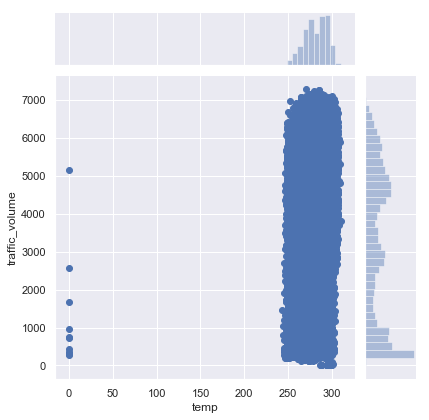

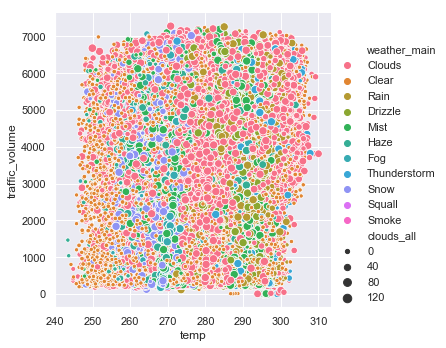

In [20]:
# NOTE: some entries have an invalid temp value of 0 Kelvin
sns.jointplot(x="temp", y="traffic_volume", data=dataset_csv)
sns.relplot(x="temp", y="traffic_volume", hue="weather_main", size="clouds_all", data=dataset_csv[dataset_csv.temp > 0.0])

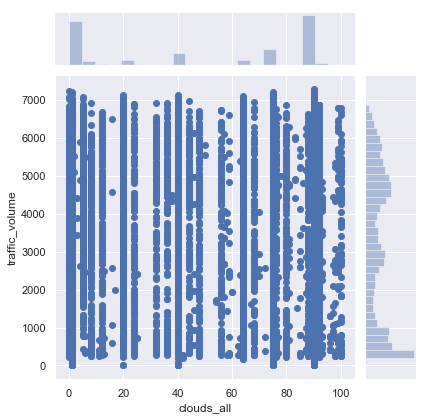

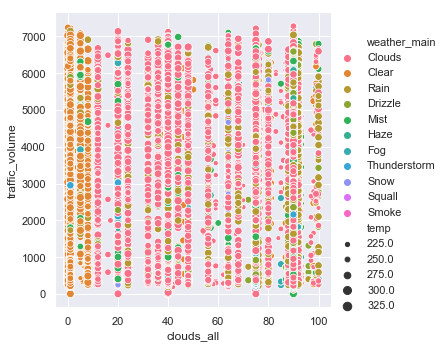

In [21]:
sns.jointplot(x="clouds_all", y="traffic_volume", data=dataset_csv)
sns.relplot(x="clouds_all", y="traffic_volume", hue="weather_main", size="temp", data=dataset_csv[dataset_csv.temp > 0.0])

## 0. Data cleaning

In [22]:
# we'll copy our dataset to the DataFrame object 'data' to clean it and
# save it as a new .csv file later (splitting it into trainning/validation and test)
data = dataset_csv.copy()

### 0.0. Removing invalid data

In [23]:
# removing entries with 0 Kelvin temperature
print(f"{data.shape} - {data.query('temp == 0.0').shape} => ", end='')

data = data.query("temp > 0.0")
print(data.shape) # removes 10 invalid examples

(48204, 9) - (10, 9) => (48194, 9)


In [24]:
# the max rain_1h value looks invalid, so we'll drop it
print(f"min: {data.rain_1h.min()}, max: {data.rain_1h.max()}, median: {data.rain_1h.median()}")
data.query("rain_1h > 0.0").sort_values(by="rain_1h", ascending=False).head()

min: 0.0, max: 9831.3, median: 0.0


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24872,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
25779,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913
10806,None,264.50,28.70,0.0,64,Rain,very heavy rain,2013-12-19 23:00:00,1190


In [25]:
data.drop(index=24872, inplace=True)
data.query("rain_1h > 0.0").sort_values(by="rain_1h", ascending=False).head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
8247,None,289.10,55.63,0.0,68,Rain,very heavy rain,2013-08-07 02:00:00,315
7179,None,295.82,44.45,0.0,76,Rain,very heavy rain,2013-06-24 11:00:00,4802
25779,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913
10806,None,264.50,28.70,0.0,64,Rain,very heavy rain,2013-12-19 23:00:00,1190
10807,None,264.50,28.70,0.0,64,Snow,light snow,2013-12-19 23:00:00,1190


Note that we removed values from the whole dataset, and only now we'll split it into train/validation and test.

However, the values we removed (0 Kelvin temperature and over 1000mm of rain in an hour) are clearly invalid, so even if we were dealing with test (never seen) data, we could confidently remove entries like these.

### 0.1. Splitting the dataset into train/validation and test

In [26]:
# FIXME should we split the dataset now?
#       and move the following changes to a function, so we can run it on the "untouched" test data later (?)

### 0.2. Adding an 'hour' column

In [27]:
data["date_time"] = pd.to_datetime(data["date_time"], format="%Y-%m-%d %H:%M:%S")
# data.set_index("date_time", inplace=True)
data["hour"] = pd.DatetimeIndex(data["date_time"]).hour

In [28]:
hour_mean = data[["hour", "temp", "traffic_volume"]].groupby("hour").mean()

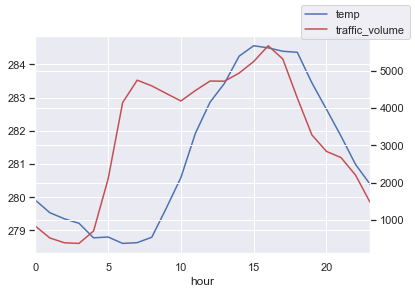

In [29]:
# plot how the temp and traffic volume varies, on avg, with the hour
ax1 = hour_mean.plot(y="temp", legend=False)
ax2 = ax1.twinx()
hour_mean.plot(y="traffic_volume", ax=ax2, legend=False, color="r")
ax1.figure.legend()
plt.show()

### 0.3. Adding holiday value to the whole day (not just at 00:00:00)

In [30]:
# NOTE: the holiday field is only annotated on the 0th hour of the day
holidays = data[data.holiday != "None"][["holiday", "date_time", "hour", "traffic_volume"]]
holidays.shape # there are 61 holidays in the data (i.e. 61 / 2189 ~= 2.79% of days)

(61, 4)

In [31]:
holidays.nunique() # NOTE: there seems to be "duplicate" entries
                   # e.g.: holidays[holidays["holiday"] == "Martin Luther King Jr Day"].query("date_time == '2018-01-15'"))

holiday           11
date_time         53
hour               1
traffic_volume    53
dtype: int64

In [32]:
holiday_dates = holidays["date_time"].dt.normalize()
holiday_dates

126     2012-10-08
1123    2012-11-12
1370    2012-11-22
2360    2012-12-25
2559    2013-01-01
           ...    
44441   2018-05-28
45547   2018-07-04
46936   2018-08-23
47330   2018-09-03
47331   2018-09-03
Name: date_time, Length: 61, dtype: datetime64[ns]

In [33]:
# obs.: since we have 48194 examples in 'data' and 2.79% of days are holidays, we should
#       obtain around 0.028 * 48194 ~= 1350 entries where data.holiday != "None"

data.loc[(data['date_time'].dt.normalize().isin(holiday_dates))].head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour
126,Columbus Day,273.08,0.0,0.0,20,Clouds,few clouds,2012-10-08 00:00:00,455,0
127,None,272.62,0.0,0.0,20,Clouds,few clouds,2012-10-08 01:00:00,336,1
128,None,271.78,0.0,0.0,1,Clear,sky is clear,2012-10-08 02:00:00,265,2
129,None,271.05,0.0,0.0,1,Clear,sky is clear,2012-10-08 03:00:00,314,3
130,None,270.63,0.0,0.0,1,Clear,sky is clear,2012-10-08 04:00:00,779,4


In [34]:
holiday_names = [row["holiday"] for index, row in holidays.iterrows()]
print(f"# of holidays: {len(holiday_names)}")

# add holiday name to holiday days on hours other than 00:00:00
for holiday_name, holiday_date in zip(holiday_names, holiday_dates):
    data.loc[(data['date_time'].dt.normalize() == holiday_date), "holiday"] = holiday_name

print(f"# of dataset examples on holidays: {data[data.holiday != 'None'].shape}")

# of holidays: 61
# of dataset examples on holidays: (1409, 10)


In [35]:
data[data.holiday != "None"].head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour
126,Columbus Day,273.08,0.0,0.0,20,Clouds,few clouds,2012-10-08 00:00:00,455,0
127,Columbus Day,272.62,0.0,0.0,20,Clouds,few clouds,2012-10-08 01:00:00,336,1
128,Columbus Day,271.78,0.0,0.0,1,Clear,sky is clear,2012-10-08 02:00:00,265,2
129,Columbus Day,271.05,0.0,0.0,1,Clear,sky is clear,2012-10-08 03:00:00,314,3
130,Columbus Day,270.63,0.0,0.0,1,Clear,sky is clear,2012-10-08 04:00:00,779,4


### 0.4. Dropping 'snow_1h' and 'weather_description' columns
They both seem redundant if we consider the 'weather_main' values.

In [36]:
data.drop(columns=["snow_1h", "weather_description"], inplace=True)

In [37]:
data.head()

,holiday,temp,rain_1h,clouds_all,weather_main,date_time,traffic_volume,hour
0,None,288.28,0.0,40,Clouds,2012-10-02 09:00:00,5545,9
1,None,289.36,0.0,75,Clouds,2012-10-02 10:00:00,4516,10
2,None,289.58,0.0,90,Clouds,2012-10-02 11:00:00,4767,11
3,None,290.13,0.0,90,Clouds,2012-10-02 12:00:00,5026,12
4,None,291.14,0.0,75,Clouds,2012-10-02 13:00:00,4918,13


### 0.5. Save the clean dataset

In [38]:
print(data.shape)
data.nunique()
# we have 40565 unique datetimes out of 48194, so it seems that there are 
# "duplicate" entries when there's more than one weather condition at the 
# same time, e.g. it's snowing and raining

(48193, 8)


holiday              12
temp               5842
rain_1h             371
clouds_all           60
weather_main         11
date_time         40564
traffic_volume     6704
hour                 24
dtype: int64

In [39]:
# make 'date_time' the index and move 'hour' to the first column
data = data.set_index("date_time")
data = data[["hour", "holiday", "temp", "rain_1h", "clouds_all", "weather_main", "traffic_volume"]]
data.head()

,hour,holiday,temp,rain_1h,clouds_all,weather_main,traffic_volume
date_time,,,,,,,
2012-10-02 09:00:00,9,None,288.28,0.0,40,Clouds,5545
2012-10-02 10:00:00,10,None,289.36,0.0,75,Clouds,4516
2012-10-02 11:00:00,11,None,289.58,0.0,90,Clouds,4767
2012-10-02 12:00:00,12,None,290.13,0.0,90,Clouds,5026
2012-10-02 13:00:00,13,None,291.14,0.0,75,Clouds,4918


In [40]:
data.to_csv("clean_dataset.csv")

### 0.6. Transform categorical features

In [41]:
# NOTE: since we'll be changing some values below, we'll make a copy of 'data' so that
#       we can rerun this cell in case we mess something up while testing the changes
df = data.copy()

Instead of turning a categorical feature with $n$ possible values into an $n$-D vector, with entries having only one non-zero — _hot_ — element, we'll drop one dimension (i.e. not use one of the values), creating an $(n-1)$-D vector to avoid the [Dummy Variable Trap](https://www.algosome.com/articles/dummy-variable-trap-regression.html).

In [42]:
# categorical attributes: "holiday", "weather_main"
df["weather_main"].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [43]:
# see the most common weather conditions
df.groupby("weather_main").size().sort_values(ascending=False)

weather_main
Clouds          15164
Clear           13381
Mist             5950
Rain             5671
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
dtype: int64

In [44]:
# dummy encoding, n-D: 
#   pd.get_dummies(df, prefix="weather", columns=["weather_main"])

# one-hot encoding, (n-1)-D:
#   pd.get_dummies(df, prefix="weather", columns=["weather_main"], drop_first=True) # drops Clear weather

weather_encoding = pd.get_dummies(df["weather_main"], drop_first=True) # drops Clear weather

df = pd.concat([df, weather_encoding], axis=1)

In [45]:
# we can now safely drop the 'weather_main' column
df.drop(columns=["weather_main"], inplace=True)

In [46]:
print(df.columns)
df.head()

Index(['hour', 'holiday', 'temp', 'rain_1h', 'clouds_all', 'traffic_volume',
       'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Snow',
       'Squall', 'Thunderstorm'],
      dtype='object')


,hour,holiday,temp,rain_1h,clouds_all,traffic_volume,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
date_time,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,9,None,288.28,0.0,40,5545,1,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,10,None,289.36,0.0,75,4516,1,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,11,None,289.58,0.0,90,4767,1,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,12,None,290.13,0.0,90,5026,1,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,13,None,291.14,0.0,75,4918,1,0,0,0,0,0,0,0,0,0


In [47]:
# obs.: comparing the value to 0 prevents accidents when running this cell twice
df["holiday"] = df["holiday"].apply(lambda h: 0 if (h == "None" or h == 0) else 1)

In [48]:
df[df["holiday"] == 1].shape # just checking to see if we still have 1409 examples on holidays and... we're good!

(1409, 16)

In [49]:
df.head()

,hour,holiday,temp,rain_1h,clouds_all,traffic_volume,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
date_time,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,9,0,288.28,0.0,40,5545,1,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,10,0,289.36,0.0,75,4516,1,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,11,0,289.58,0.0,90,4767,1,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,12,0,290.13,0.0,90,5026,1,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,13,0,291.14,0.0,75,4918,1,0,0,0,0,0,0,0,0,0


### 0.7. Split 'date_time' into 'weekday' and 'weekofyear'

In [50]:
# NOTE: by not using the 'date_time' column we're only losing the year information from the original dataset, 
#       since we have 'hour', 'weekday' and 'weekofyear'
df.insert(1, "weekday", pd.DatetimeIndex(df.index).weekday)
df.insert(2, "weekofyear", pd.DatetimeIndex(df.index).weekofyear)
df.head()

,hour,weekday,weekofyear,holiday,temp,rain_1h,clouds_all,traffic_volume,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
date_time,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,9,1,40,0,288.28,0.0,40,5545,1,0,0,0,0,0,0,0,0,0
2012-10-02 10:00:00,10,1,40,0,289.36,0.0,75,4516,1,0,0,0,0,0,0,0,0,0
2012-10-02 11:00:00,11,1,40,0,289.58,0.0,90,4767,1,0,0,0,0,0,0,0,0,0
2012-10-02 12:00:00,12,1,40,0,290.13,0.0,90,5026,1,0,0,0,0,0,0,0,0,0
2012-10-02 13:00:00,13,1,40,0,291.14,0.0,75,4918,1,0,0,0,0,0,0,0,0,0


In [51]:
# FIXME turn 'hour' values into sin(hour) and cos(hour)

## 1. $(0.25 pts)$ Split the data for providing your results and avoid overfitting.
Keep in mind that friends don’t let friends use testing data for training :-).

In [52]:
# FIXME shoudl we use the "untouched" data and only then make changes to it? (e.g. adding columns, one-hot encoding, etc.)
data = df

In [53]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886

In [54]:
# we'll split the dataset we've just cleaned into 60:20:20:
# - test: 20%
# - train & validation: 80%
#   - train: 60%
#   - validation: 20%

from sklearn.model_selection import train_test_split

print(f"total: {data.shape}")

train_data, test_validation_data = train_test_split(data, train_size=0.6, test_size=0.4, random_state=RANDOM_SEED)
print(train_data.shape) # 60%
print(test_validation_data.shape) # 40%

# now we split test and validation
test_data, validation_data = train_test_split(test_validation_data, train_size=0.5, test_size=0.5, random_state=RANDOM_SEED)
print(test_data.shape) # 20% of total
print(validation_data.shape) # 20% of total

total: (48193, 18)
(28915, 18)
(19278, 18)
(9639, 18)
(9639, 18)


In [55]:
# visualize the first values of each set
def columns_not_to_show(dataframe, columns):
    return dataframe.columns[~dataframe.columns.isin(columns)]

dont_show = (["Clouds", "Drizzle", "Fog", "Haze", "Mist", "Rain", "Smoke", "Snow", "Squall", "Thunderstorm"] + 
             ["hour", "weekday", "weekofyear"])

print(train_data[columns_not_to_show(train_data, columns=dont_show)]
      .sort_values("date_time").head())
print(validation_data[columns_not_to_show(validation_data, columns=dont_show)]
      .sort_values("date_time").head())

print(test_data[columns_not_to_show(test_data, columns=dont_show)]
      .sort_values("date_time").head())

                     holiday    temp  rain_1h  clouds_all  traffic_volume
date_time                                                                
2012-10-02 10:00:00        0  289.36      0.0          75            4516
2012-10-02 12:00:00        0  290.13      0.0          90            5026
2012-10-02 14:00:00        0  291.72      0.0           1            5181
2012-10-02 15:00:00        0  293.17      0.0           1            5584
2012-10-02 17:00:00        0  294.14      0.0          20            5791
                     holiday    temp  rain_1h  clouds_all  traffic_volume
date_time                                                                
2012-10-02 09:00:00        0  288.28      0.0          40            5545
2012-10-02 13:00:00        0  291.14      0.0          75            4918
2012-10-02 16:00:00        0  293.86      0.0           1            6015
2012-10-03 15:00:00        0  295.17      0.0           1            5692
2012-10-03 23:00:00        0  285.26  

In [56]:
# obs.: from now on, instead of the entire dataset ('data'), we'll use: 'train_data', 'validation_data', and 'test_data'
data = None
df = None

### Normalize values

It's important we **normalize our trainning data** and save the transformation we made to it so we can use the same values once we deal with validation and test (i.e. we don't want to be normalizing the test and validation sets based on their own values).

In [57]:
# NOTE: should we normalize 'traffic_volume', since it's our target?
# FIXME we have to change this list if new columns are added
attrs_to_normalize = ["traffic_volume", "temp", "rain_1h", "clouds_all", "hour", "weekday", "weekofyear"]
def get_stats(dataframe, columns, operations=['min', 'max', 'mean', 'median', 'std']):
    return dataframe[columns].agg(operations)

Z-score normalization: $ x \leftarrow \dfrac{x - \mu}{\sigma}$ (makes the mean 0 and the standard deviation 1)

In [58]:
# mu = mean, sigma = stddev
def z_score(x, mu, sigma):
    return (x - mu) / sigma

def normalize(dataset, stats):
    for col in stats:
        col_mean = stats.loc["mean", col]
        col_stddev = stats.loc["std", col]
        dataset.loc[:, col] = dataset.loc[:, col].apply(lambda x: z_score(x, mu=col_mean, sigma=col_stddev))


In [59]:
# NOTE: we must use 'train_stats' when normalizing 'validation_data' and 'test_data' aswell
train_stats = get_stats(train_data, columns=attrs_to_normalize).copy()

In [60]:
train_stats

,traffic_volume,temp,rain_1h,clouds_all,hour,weekday,weekofyear
min,0.000000,243.620000,0.000000,0.000000,0.000000,0.000000,1.000000
max,7260.000000,310.070000,31.750000,100.000000,23.000000,6.000000,53.000000
mean,3251.698876,281.311355,0.131097,49.469929,11.366592,2.992426,26.529483
median,3382.000000,282.610000,0.000000,64.000000,11.000000,3.000000,27.000000
std,1989.789863,12.718151,0.962435,38.981579,6.947451,2.002828,14.805137


In [61]:
normalize(train_data, train_stats)
normalize(validation_data, train_stats)
normalize(test_data, train_stats)

c:\users\camds\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [62]:
# we should now see mean~=0 and std~=1 for all attributes
get_stats(train_data, columns=attrs_to_normalize)

,traffic_volume,temp,rain_1h,clouds_all,hour,weekday,weekofyear
min,-1.634192e+00,-2.963588e+00,-1.362139e-01,-1.269059e+00,-1.636081e+00,-1.494100e+00,-1.724367e+00
max,2.014434e+00,2.261228e+00,3.285302e+01,1.296255e+00,1.674486e+00,1.501663e+00,1.787928e+00
mean,-5.639618e-17,1.445168e-15,-1.326969e-17,-3.587731e-17,9.669672e-17,6.905153e-17,8.649872e-17
median,6.548487e-02,1.021096e-01,-1.362139e-01,3.727420e-01,-5.276637e-02,3.781614e-03,3.178066e-02
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [63]:
# we should now see mean close to 0 and std close to 1
get_stats(validation_data, columns=attrs_to_normalize)

,traffic_volume,temp,rain_1h,clouds_all,hour,weekday,weekofyear
min,-1.633187,-2.916411,-0.136214,-1.269059,-1.636081,-1.494100,-1.724367
max,2.024486,2.166875,28.509871,1.296255,1.674486,1.501663,1.787928
mean,-0.002413,-0.004492,-0.003558,-0.001274,0.003695,-0.020409,-0.005134
median,0.039854,0.087957,-0.136214,0.372742,-0.052766,0.003782,0.031781
std,0.999531,0.991586,0.984716,1.003229,1.004600,1.002367,1.004213


In [64]:
# we should now see mean close to 0 and std close to 1
get_stats(test_data, columns=attrs_to_normalize)

,traffic_volume,temp,rain_1h,clouds_all,hour,weekday,weekofyear
min,-1.633690,-2.981672,-0.136214,-1.269059,-1.636081,-1.494100,-1.724367
max,2.004886,2.117340,57.665081,1.296255,1.674486,1.501663,1.787928
mean,0.023709,-0.014208,-0.000366,-0.011294,0.019882,0.000829,-0.007566
median,0.094131,0.047070,-0.136214,0.372742,-0.052766,0.003782,0.031781
std,0.992685,1.004940,1.210833,1.000922,0.990190,1.005025,1.007924


### Save the split data, normalized with the train set values of mean and stddev

In [65]:
train_data.to_csv("train_dataset.csv")
validation_data.to_csv("validation_dataset.csv")

test_data.to_csv("test_dataset.csv") # and now don't touch it anymore

## 2. $(3 pts)$ Perform Linear Regression.
**You should implement your solution** and compare it with [sklearn.linear model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (“linear model fitted by minimizing a regularized empirical loss with [SGD](https://scikit-learn.org/stable/modules/sgd.html)”). What are the conclusions?

In [66]:
import warnings

### Hypothesis: 
$h_{\theta}(x) = \theta^T x = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$, where:

- $x = (x_0, x_1, ..., x_n)$, with $x_0 = 1$ and the values from $1$ to $n$ are taken from rows of our dataset.
- $\theta = (\theta_0, \theta_1, ..., \theta_n)$ are the parameters.

### Cost function: 
$J(\theta) = \dfrac{1}{2m} \sum\limits_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2 \; \Longrightarrow \; 
\dfrac{\partial J(\theta)}{\partial \theta_j} = \dfrac{1}{m} \sum\limits_{i=1}^m (\,(h_{\theta}(x^{(i)}) - y^{(i)}) \, x_j^{(i)}\,)$, where:

- $m$ is the number of examples.
- $n$ is the number of features.
- $x^{(i)} = (1, x_1^{(i)}, ..., x_n^{(i)})$ are the features of the $i^{th}$ training example ($\forall{i},\,x_0^{(i)} = 1$).
- $x_j^{(i)}$ is the value of feature $j$ of the $i^{th}$ training example.
- $y = (y^{(1)}, ..., y^{(m)})$ are the target values.
- $y^{(i)}$ is the target value for the $i^{th}$ training example.

In [67]:
# theta is an array of 'params' of shape=(n_features, 1)
# -> (n+1) x 1

# X is a matrix of 'data', with each line being an 'example', of shape=(n_examples, n_features)
# -> m x (n+1)

# y is an array of 'target' values for each example of shape=(n_examples, 1)
# -> m x 1

''' Returns a scalar, corresponding to the value of J(theta). '''
def loss_function(theta, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    m = X.shape[0] # number of examples
    
    loss = X.dot(theta) # estimate of y (h_theta(X))
    loss = loss - y     # error between estimate and real y values (h_theta(X) - y)
    loss = loss**2      # squared error of each element (h_theta(X) - y)**2
    
    # J(theta) = 1 / (2m) * sum((h_theta(X) - y)**2)
    return 0.5 * (1 / m) * loss.sum()

    #return 0.5 * (1 / m) * np.sum((X.dot(theta) - y)**2)


In [68]:
''' Returns a (n+1) x 1 array with the gradient values for each theta_j. '''
def eval_gradient(theta, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    m = X.shape[0]
    
    # h_theta(X) = X • theta
    loss_partial_theta = X.dot(theta)
    
    # h_theta(X) - y
    loss_partial_theta = loss_partial_theta - y
    
    # X_transposed • (h_theta(X) - y)
    loss_partial_theta = X.T.dot(loss_partial_theta)
    
    # gradient for every theta (an array with each j-th element being the partial derivative of J with respect to theta_j)
    return (1 / m) * loss_partial_theta

    #return (1 / m) * np.dot(X.T, X.dot(theta) - y)


### Gradient descent: 
Given the learning rate $\alpha$:

**repeat {** $\theta_j := \theta_j - \alpha \dfrac{\partial J(\theta)}{\partial \theta_j}$ 
**}** (simultaneously update for $j = 0, 1, ..., n$)

If we consider a matrix $\mathbb{X}$, with each row $i$ equal to $x^{(i)}$ transposed ($1 \leq i \leq m$), we have:
$\theta := \theta - \alpha (\,\frac{1}{m} \mathbb{X}^T (\mathbb{X} \theta - y)\,)$

In [69]:
np.random.seed(RANDOM_SEED) # use for reproducibility

Perform one epoch of gradient descent:

In [70]:
''' Returns a (n+1) x 1 array with the updated values for each parameter theta_j. 

    Assumes that 'X' is a matrix with shape=(n_examples, n_features), with a first column of 1's, and that
    'y' is an array of shape=(n_examples, 1) with the corresponding target values for each row of 'X'.
    
    n_examples = m
    n_features = n+1 (x_0 = 1 for every row i in [1, m], i.e. X[i, 0] = 1)
'''
def stochastic_GD_step(theta, X, y, learning_rate):
    X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
    for sample_X, sample_y in zip(X, y):
        theta_grad = eval_gradient(theta, sample_X.reshape(1, -1), sample_y)
        theta = theta - learning_rate * theta_grad
    return theta

In [71]:
def shuffled_X_y(X, y, seed):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    p = np.random.permutation(m)
    return X[p], y[p]

In [72]:
''' Returns a (n+1) x 1 array with the updated values for each parameter theta_j. 

    If batch_size is specified, acts as a Mini Batch GD, otherwise, it works like Vanilla GD.

    Assumes that 'X' is a matrix with shape=(n_examples, n_features), with a first column of 1's, and that
    'y' is an array of shape=(n_examples, 1) with the corresponding target values for each row of 'X'.
    
    n_examples = m
    n_features = n+1 (x_0 = 1 for every row i in [1, m], i.e. X[i, 0] = 1)
'''
def batch_GD_step(theta, X, y, learning_rate, batch_size=None):
    if not batch_size:
        # vanilla
        theta_grad = eval_gradient(theta, X, y)
        theta = theta - learning_rate * theta_grad
    else:
        # mini batch
        X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
        for batch_X, batch_y in get_batches(X, y, batch_size):
            theta_grad = eval_gradient(theta, batch_X, batch_y)
            theta = theta - learning_rate * theta_grad
    return theta

In [73]:
def get_batches(X, y, batch_size):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]    
    try:
        return zip(np.split(X, batch_size), np.split(y, batch_size))
    except:
        warnings.warn(f"batch_size={batch_size} does not result in an equal division for shapes: " +
                      f"{X.shape} of X, and {y.shape} of y. The last batch will have size {m % batch_size}")
        return zip(np.array_split(X, batch_size), np.array_split(y, batch_size))
    

Run gradient descent for a specified number of epochs:

In [74]:
def __gradient_descent(theta, train_X_y, validation_X_y, learning_rate, n_epochs, 
                       GD_step_func, batch_size_kwarg_if_mini_batch=None):
    if batch_size_kwarg_if_mini_batch == None:
        batch_size_kwarg_if_mini_batch = {}
        
    X, y = train_X_y
    val_X, val_y = validation_X_y
    
    loss = loss_function(theta, X, y)
    val_loss = loss_function(theta, val_X, val_y)
    
    # stores the best values for minimizing J(theta) on the validation set
    best_params = theta.copy()
    best_val_loss = val_loss
    
    # save the loss values for plotting
    plot_dict = { 
        "best_val_loss": best_val_loss, 
        "best_val_loss_epoch": 0, 
        "loss": [loss], # training set
        "val_loss": [val_loss] # validation set
    }
    
    for epoch in range(n_epochs):
        theta = GD_step_func(theta, X, y, learning_rate, **batch_size_kwarg_if_mini_batch)
    
        loss = loss_function(theta, X, y)
        plot_dict["loss"].append(loss) # training set
        
        val_loss = loss_function(theta, val_X, val_y)
        plot_dict["val_loss"].append(val_loss) # validation set
        
        # update the best loss and store the current parameters if val_loss < best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = theta.copy()
            plot_dict["best_val_loss_epoch"] = epoch + 1
        
        print(f"({epoch + 1} / {n_epochs}) training: {loss:.4f} | validation: {val_loss:.4f}", end='\r')
        
    plot_dict["best_val_loss"] = best_val_loss
    return best_params, plot_dict
    

### Compute $\mathbb{X}$ and $y$
Let's add our datasets' features to $\mathbb{X}$ (plus $x_0 = 1$) and it's target values to $y$, so we can train our model.

For this, we'll make the target value 'traffic_volume' column the last one in the dataset so we can easily split the data.

In [75]:
columns = [col for col in train_data.columns.values if col != "traffic_volume"]

train_data = train_data[columns + ["traffic_volume"]]
validation_data = validation_data[columns + ["traffic_volume"]]

test_data = test_data[columns + ["traffic_volume"]]

In [76]:
# NOTE: assumes target values are in the last column of 'dataset'
def split_X_y(dataset):
    dataset = dataset.to_numpy(copy=True)
    m = dataset.shape[0] # number of examples
    X = np.c_[np.ones(shape=(m, 1)), dataset[:, :-1]] # add a column of x_0's equal to 1
    y = dataset[:, -1:]
    return X, y

In [77]:
train_X_y = split_X_y(train_data)
validation_X_y = split_X_y(validation_data)

In [78]:
# # check if the values are correct
# X, y = train_X_y
# for i in range(2):
#     print(f"dataset: {train_data.iloc[i].values}\n") # should be equal to np.append(X[i, 1:], y[i])
#     print(f"check:   {np.append(X[i, 1:], y[i])}\n")
#     print(f"X: {X[i]}\n")
#     print(f"y: {y[i]}\n\n")

### Run our implementation

In [79]:
''' Returns the initial theta (n+1) x 1 array. '''
def init_params(n_features, zeros=False):
    if zeros:
        return np.zeros(shape=(n_features, 1))
    else:
        # Xavier initialization
        return np.sqrt(2 / n_features) * np.random.randn(n_features, 1)
    

In [80]:
def train(params, train_X_y, validation_X_y, learning_rate, n_epochs, batch_size=None, GD_flavor="vanilla"):
    if GD_flavor == "vanilla":        
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=batch_GD_step)

    elif GD_flavor == "mini batch":
        if batch_size == None:
            warnings.warn("You should specify batch_size when using GD_flavor='mini batch'.")
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=batch_GD_step, 
                                                    batch_size_kwarg_if_mini_batch={ "batch_size": batch_size })
        plot_dict["batch_size"] = batch_size

    elif GD_flavor == "stochastic":
        best_params, plot_dict = __gradient_descent(params, train_X_y, validation_X_y, learning_rate, n_epochs, 
                                                    GD_step_func=stochastic_GD_step)

    else:
        raise ValueError("GD_flavor must be one of the following values: 'vanilla', 'stochastic', or 'mini batch'.")
        
    plot_dict["learning_rate"] = learning_rate
    plot_dict["n_epochs"]      = n_epochs
    plot_dict["flavor"]        = GD_flavor
    
    return best_params, plot_dict
        

In [81]:
X, _ = train_X_y
n_examples, n_features = X.shape # m x (n+1)
X.shape

(28915, 18)

#### Vanilla Gradient Descent

In [82]:
best_params, plot_dict = train(
    init_params(n_features, zeros=True), 
    train_X_y, validation_X_y, 
    learning_rate=0.0005, 
    n_epochs=10000, 
    GD_flavor="vanilla")

In [83]:
print("Best validation loss: {best_val_loss:.6f} (at epoch {best_val_loss_epoch})".format(
    best_val_loss=plot_dict['best_val_loss'], 
    best_val_loss_epoch=plot_dict['best_val_loss_epoch']))

# best_params # best values for theta obtained during trainning

Best validation loss: 0.418456 (at epoch 10000)


Text(0.5, 1.0, 'vanilla GD\n(10000 epochs with α = 0.0005)')

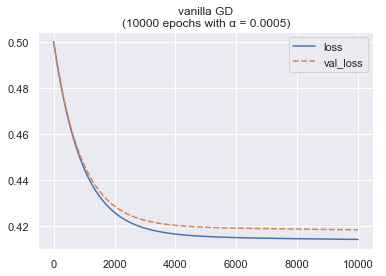

In [84]:
plot_title = "{flavor} GD\n({n_epochs} epochs with α = {learning_rate})".format(
    flavor=plot_dict['flavor'], 
    n_epochs=plot_dict['n_epochs'], 
    learning_rate=plot_dict['learning_rate'])

# leave only "loss" and "val_loss" for plotting
loss_data = pd.DataFrame({k: v for k, v in plot_dict.items() if (k == "loss" or k == "val_loss")})

sns.lineplot(data=loss_data).set_title(plot_title)

#### Mini Batch Gradient Descent

In [85]:
best_params, plot_dict = train(
    init_params(n_features, zeros=True), 
    train_X_y, validation_X_y, 
    learning_rate=0.0005, 
    n_epochs=5000, 
    batch_size=32, 
    GD_flavor="mini batch")

c:\users\camds\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: batch_size=32 does not result in an equal division for shapes: (28915, 18) of X, and (28915, 1) of y. The last batch will have size 19
  


In [86]:
print("Best validation loss: {best_val_loss:.6f} (at epoch {best_val_loss_epoch})".format(
    best_val_loss=plot_dict['best_val_loss'], 
    best_val_loss_epoch=plot_dict['best_val_loss_epoch']))

# best_params # best values for theta obtained during trainning

Best validation loss: 0.413778 (at epoch 5000)


Text(0.5, 1.0, 'mini batch GD\n(5000 epochs with α = 0.0005 and 32 batch size)')

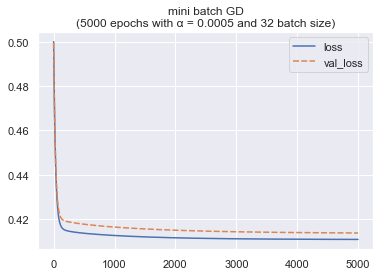

In [87]:
plot_title = "{flavor} GD\n({n_epochs} epochs with α = {learning_rate} and {batch_size} batch size)".format(
    flavor=plot_dict['flavor'], 
    n_epochs=plot_dict['n_epochs'], 
    learning_rate=plot_dict['learning_rate'], 
    batch_size=plot_dict['batch_size'])

# leave only "loss" and "val_loss" for plotting
loss_data = pd.DataFrame({k: v for k, v in plot_dict.items() if (k == "loss" or k == "val_loss")})

sns.lineplot(data=loss_data).set_title(plot_title)

#### Stochastic Gradient Descent

In [88]:
best_params, plot_dict = train(
    init_params(n_features, zeros=True), 
    train_X_y, validation_X_y, 
    learning_rate=0.0005, 
    n_epochs=1000, 
    GD_flavor="stochastic")

In [89]:
print("Best validation loss: {best_val_loss:.6f} (at epoch {best_val_loss_epoch})".format(
    best_val_loss=plot_dict['best_val_loss'], 
    best_val_loss_epoch=plot_dict['best_val_loss_epoch']))

# best_params # best values for theta obtained during trainning

Best validation loss: 0.413270 (at epoch 924)


Text(0.5, 1.0, 'stochastic GD\n(1000 epochs with α = 0.0005)')

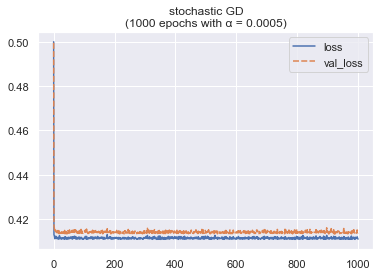

In [90]:
plot_title = "{flavor} GD\n({n_epochs} epochs with α = {learning_rate})".format(
    flavor=plot_dict['flavor'], 
    n_epochs=plot_dict['n_epochs'], 
    learning_rate=plot_dict['learning_rate'])

# leave only "loss" and "val_loss" for plotting
loss_data = pd.DataFrame({k: v for k, v in plot_dict.items() if (k == "loss" or k == "val_loss")})

sns.lineplot(data=loss_data).set_title(plot_title)

### Normal equation: $\theta = (\mathbb{X}^T \mathbb{X})^{-1} \mathbb{X}^T y$

In [91]:
''' Returns a (n+1) x 1 array with the parameter values theta_j that minimize J(theta). '''
def normal_equation(X, y):
    # minimizes the sum of the square differences
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    

In [92]:
best_theta = normal_equation(*train_X_y)
print("Best possible parameter values for the training set:")
best_theta

Best possible parameter values for the training set:


array([[-0.01763036],
       [ 0.33660688],
       [-0.15623968],
       [-0.0183425 ],
       [-0.51306228],
       [ 0.11118184],
       [-0.0237485 ],
       [ 0.04527163],
       [ 0.13972808],
       [-0.03783727],
       [-0.0827117 ],
       [ 0.16028885],
       [-0.05586826],
       [-0.01942452],
       [-0.25373021],
       [-0.00626831],
       [-0.50006478],
       [-0.15565497]])

In [93]:
print("Best possible loss for the trainning set:")
loss_function(best_theta, *train_X_y)

Best possible loss for the trainning set:


0.4107871844843783

In [94]:
print("Loss for the validation set:")
loss_function(best_theta, *validation_X_y)

Loss for the validation set:


0.41350169748183047

### scikit-learn SGD Regressor

In [103]:
from sklearn import linear_model

# tol : stopping parameter
# eta0 = constant learning rate 
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3) 

X, y = train_X_y
clf.fit(X, y)

c:\users\camds\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [105]:
X, y = validation_X_y

y_predicted = clf.predict(X)

# Calculate loss
loss = y_predicted - y
loss = loss**2
loss = 0.5 * (1 / X.shape[0]) * loss.sum()
print("Our loss:",loss)

# sklearn 
print("Module's loss:",clf.score(X,y))

Our loss: 5754.156132267465
Module's loss: 0.16939289006545666


## 3. $(0.75 pts)$ Plot the cost function $vs.$ number of iterations in the training set and analyze the model complexity.
What are the conclusions? What are the actions after such analyses?

## 4. $(1 pts)$ Use different Gradient Descent (GD) learning rates when optimizing. Compare the GD-based solutions with Normal Equation.
**You should implement your solutions**. What are the conclusions?

## 5. $(4 pts)$ Prepare a 4-page (max.) report with all your findings.
It is UP TO YOU to convince the reader that you are proficient on linear regression and the choices it entails.

## 6. $(1 pts)$ You should provide a single Jupyter notebook with your solution (in Python 3 code).